In [42]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, output_file, vplot
from bokeh.models import Range1d, CrosshairTool

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")

from electronfactors.reports.interactive import *
from electronfactors.model.utilities import *
from electronfactors.visuals.histogram import create_histogram

from electronfactors.visuals.utilities import create_green_cm

In [2]:
green_cm = create_green_cm()

In [3]:
output_file('electronfactors.html')

In [4]:
# output_notebook()

In [5]:
energy = 9
applicator = 10
width, length, eqPonA, factor, label = pull_data(
    energy=energy, applicator=applicator, return_label=True)

In [6]:
model = create_model(width, eqPonA, factor)
model_value = model(width, eqPonA)
residual = factor - model_value
pred_diff = calculate_percent_prediction_differences(width, eqPonA, factor, keep_nans=True)

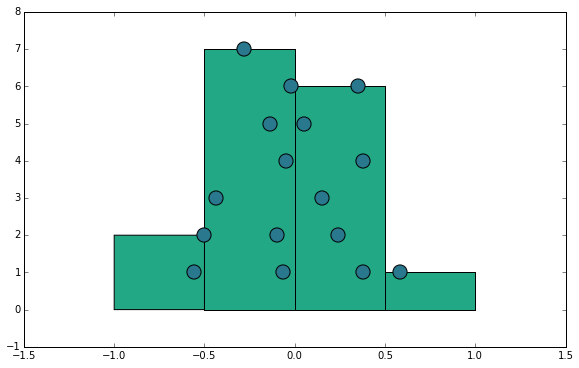

In [7]:
bins=np.arange(-1.0, 1+0.5, 0.5)

pc_residual = 100 * (factor - model_value) / factor
hist_height = create_histogram(pc_residual, bins=bins)

In [8]:
transformed_mesh = dict()
result = create_transformed_plot_mesh(width, length, factor)
reference = ~np.isnan(np.ravel(result[2]))
transformed_mesh['width'] = np.ravel(result[0])[reference]
transformed_mesh['length'] = np.ravel(result[1])[reference]
transformed_mesh['factor'] = np.ravel(result[2])[reference]
transformed_mesh['eqPonA'] = to_eqPonA(
    transformed_mesh['width'], transformed_mesh['length'])

native_mesh = dict()
result = create_native_plot_mesh(width, eqPonA, factor)
reference = ~np.isnan(np.ravel(result[2]))
native_mesh['width'] = np.ravel(result[0])[reference]
native_mesh['eqPonA'] = np.ravel(result[1])[reference]
native_mesh['factor'] = np.ravel(result[2])[reference]
native_mesh['length'] = to_length(
    native_mesh['width'], native_mesh['eqPonA'])

In [9]:
np.sum(reference)

731

In [10]:
from matplotlib import colors

In [11]:
all_factor = np.hstack([transformed_mesh['factor'], native_mesh['factor'], factor])

vmin = np.nanmin(all_factor)
vmax = np.nanmax(all_factor)

def find_colour(factor):
    colour_reference = (factor - vmin) / (vmax - vmin)
    rgb = green_cm(colour_reference)
    rgb = rgb[:, 0:3]
    colour = [colors.rgb2hex(tuple(item)) for item in rgb]
    
    return colour

In [12]:
vmin

0.95132253363155472

In [13]:
colour = find_colour(factor)
colour

['#d2e21b',
 '#472d7b',
 '#69cd5b',
 '#29798e',
 '#bade28',
 '#26828e',
 '#1fa188',
 '#b0dd2f',
 '#bade28',
 '#2eb37c',
 '#67cc5c',
 '#453581',
 '#84d44b',
 '#fde725',
 '#20938c',
 '#42be71']

In [14]:
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.plotting import figure, gridplot

In [15]:
data = dict(
    width=width,
    length=length,
    eqPonA=np.around(eqPonA, decimals=3),
    factor=np.around(factor, decimals=3),
    model_value=np.around(model_value, decimals=3),
    pc_residual=np.around(pc_residual, decimals=1),
    pred_diff=np.around(pred_diff, decimals=1),
    colour=colour,
    hist_height=hist_height,
    label=label,
    zeros=np.zeros(len(factor))
)

measurements_source = ColumnDataSource(data)

In [16]:
transformed_hover_width = [" %0.1f cm" % (num) for num in transformed_mesh['width']]
transformed_hover_length = [" %0.1f cm" % (num) for num in transformed_mesh['length']]
transformed_hover_eqPonA = [" %0.2f cm^-1" % (num) for num in transformed_mesh['eqPonA']]
transformed_hover_factor = [" %0.3f" % (num) for num in transformed_mesh['factor']]

transformed_data = dict(
    width=transformed_mesh['width'],
    length=transformed_mesh['length'],
    eqPonA=transformed_mesh['eqPonA'],
    factor=transformed_mesh['factor'],
    zeros=np.zeros(len(transformed_mesh['factor'])),
    colour=find_colour(transformed_mesh['factor']),
    hover_width=transformed_hover_width,
    hover_length=transformed_hover_length,
    hover_eqPonA=transformed_hover_eqPonA,
    hover_factor=transformed_hover_factor    
)

transformed_source = ColumnDataSource(transformed_data)

In [17]:
native_hover_width = [" %0.1f cm" % (num) for num in native_mesh['width']]
native_hover_length = [" %0.1f cm" % (num) for num in native_mesh['length']]
native_hover_eqPonA = [" %0.2f cm^-1" % (num) for num in native_mesh['eqPonA']]
native_hover_factor = [" %0.3f" % (num) for num in native_mesh['factor']]

native_data = dict(
    width=native_mesh['width'],
    length=native_mesh['length'],
    eqPonA=native_mesh['eqPonA'],
    factor=native_mesh['factor'],
    zeros=np.zeros(len(native_mesh['factor'])),
    colour=find_colour(native_mesh['factor']),
    hover_width=native_hover_width,
    hover_length=native_hover_length,
    hover_eqPonA=native_hover_eqPonA,
    hover_factor=native_hover_factor  
)

native_source = ColumnDataSource(native_data)

In [18]:
columns = [
    TableColumn(field="label", title="Label"),
    TableColumn(field="width", title="Width (cm)"),
    TableColumn(field="length", title="Length (cm)"),
    TableColumn(field="eqPonA", title="P/A (cm^-1)"),
    TableColumn(field="factor", title="Cutout factor"),
    TableColumn(field="model_value", title="Model factor"),
    TableColumn(field="pc_residual", title="Residual (%)"),
    TableColumn(field="pred_diff", title="Prediction Diff. (%)"),
]

data_table = DataTable(
    source=measurements_source, columns=columns, width=1000, height=500)

In [19]:
from bokeh.models import Rect

In [20]:
tools = "box_select, tap, crosshair"

unselect_rectangle = Rect(line_alpha=0, fill_alpha=0)



In [21]:
native_y_range = Range1d(
    native_data['eqPonA'].min() - 0.005 - native_data['eqPonA'].ptp()*0.03, 
    native_data['eqPonA'].max() + 0.005 + native_data['eqPonA'].ptp()*0.03)
native_x_range = Range1d(
    native_data['width'].min() - 0.05 - native_data['width'].ptp()*0.03, 
    native_data['width'].max() + 0.05 + native_data['width'].ptp()*0.03)


native = figure(
    tools=tools, width=450, height=350, 
    title="Native domain", 
    x_axis_label="Width (cm)", y_axis_label="Perimeter / Area cm^-1)",
    x_range=native_x_range, y_range=native_y_range)
native.rect(
    'width', 'eqPonA', 0.1, 0.01, alpha=0, source=transformed_source,
    name='native_invis')
native.rect(
    'width', 'eqPonA', 0.1, 0.01, color='colour', source=native_source,
    name='native_visible')
native.circle(
    'width', 'eqPonA', source=measurements_source, 
    size=10, fill_color='colour', line_color='black')
render_invis = native.select(name='native_invis')
render_invis.nonselection_glyph = unselect_rectangle
render_vis = native.select(name='native_visible')
render_vis.nonselection_glyph = unselect_rectangle

tooltips = [
    ("Width", "@hover_width"),
    ("Length", "@hover_length"),
    ("P/A", "@hover_eqPonA"),
    ("Factor", "@hover_factor"),
]
native.add_tools(HoverTool(
        tooltips=tooltips,
        renderers=render_vis))

In [22]:
trans_y_range = Range1d(
    transformed_data['length'].min() - 0.05 - transformed_data['length'].ptp()*0.03, 
    transformed_data['length'].max() + 0.05)
trans_x_range = Range1d(
    transformed_data['width'].min() - 0.05 - transformed_data['width'].ptp()*0.03, 
    transformed_data['width'].max() + 0.05 + transformed_data['width'].ptp()*0.03)

transformed = figure(
    tools=tools, width=450, height=350, 
    title="Transformed domain", 
    x_axis_label="Width (cm)", y_axis_label="Length (cm)",
    x_range=trans_x_range, y_range=trans_y_range)
transformed.rect(
    'width', 'length', 0.1, 0.1, alpha=0, source=native_source,
    name='trans_invis')
transformed.rect(
    'width', 'length', 0.1, 0.1, color='colour', source=transformed_source,
    name='trans_visible')
transformed.circle(
    'width', 'length', source=measurements_source, 
    size=10, fill_color='colour', line_color='black')
render_invis = transformed.select(name='trans_invis')
render_invis.nonselection_glyph = unselect_rectangle
render_vis = transformed.select(name='trans_visible')
render_vis.nonselection_glyph = unselect_rectangle

tooltips = [
    ("Width", "@hover_width"),
    ("Length", "@hover_length"),
    ("P/A", "@hover_eqPonA"),
    ("Factor", "@hover_factor"),
]
transformed.add_tools(HoverTool(
        tooltips=tooltips,
        renderers=render_vis))


In [43]:
mesh_factors = np.hstack([transformed_mesh['factor'], native_mesh['factor']])
colour_bar_range = Range1d(
    np.floor(100*mesh_factors.min())/100, 
    np.ceil(100*mesh_factors.max())/100)

colour_bar = figure(
    tools=tools, width=135, height=350, title=None,
    y_range=colour_bar_range,
    y_axis_label="Factor")
colour_bar.rect(
    'zeros', 'factor', 0.5, 0.0005, name='colour_bar_trans',
    source=transformed_source, color='colour')
render = colour_bar.select(name='colour_bar_trans')
render.nonselection_glyph = unselect_rectangle
colour_bar.rect(
    'zeros', 'factor', 0.5, 0.0005, name='colour_bar_native',
    source=native_source, color='colour')
render = colour_bar.select(name='colour_bar_native')
render.nonselection_glyph = unselect_rectangle
colour_bar.rect(
    'zeros', 'factor', 0.5, 0.0005, name='colour_bar_meas',
    source=measurements_source, alpha=0)
render = colour_bar.select(name='colour_bar_meas')
render.nonselection_glyph = unselect_rectangle

crosshair = colour_bar.select(type=CrosshairTool)
crosshair.dimensions = ['width']

colour_bar.xgrid.grid_line_color = None
colour_bar.ygrid.grid_line_color = None
colour_bar.xaxis.major_label_text_font_size = '0pt'
colour_bar.xaxis.major_tick_line_color = None
colour_bar.xaxis.minor_tick_line_color = None

In [44]:
np.floor(1000*mesh_factors.min())/1000

0.95099999999999996

In [45]:
p = gridplot([[colour_bar, native, transformed]], toolbar_location=None)
test = vplot(p, data_table)
show(test)